# Chapter 33- Beta rhythms from E-I Network
This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display an pyramidal - Interneuronal Network Gamma (PING) network entrain excitatory neurons (E-cells). Beta rhythms are 12-30 Hz, thus the firing of the E-cells must be within this range. We model 200 E-cells with an RTM model and the 50 PING cells with a WB model.

requirements:

 bmtk

 NEURON 7.4+

### Create nodes
The PING network, E-cells, and external input nodes are defined

In [1]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 200

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

# ING network
n_I = 50

net.add_nodes(N=n_I, pop_name='PING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules 

We add connections based on a probability defined below. To prevent autapses, if the node_id is equal between source and targe cell, no connection is made.

In [2]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

### Creating ING Edges

Probabilities and conductances that are commented are taken from chapter 33 of Borgers' book. Inhibitory connections between PING cells are added; Inhibitory connections from PING cells to E - cells are added; Excitatory connections between E-cells and PING cells are added.

In [3]:
g_ee = 0
g_ei = 0.1  #0.25
g_ie = 0.5  #0.5
g_ii = 0.5  #0.5

p_ee = 0.5  # 0.5
p_ei = 0.5  # 0.5
p_ie = 0.5  # 0.5
p_ii = 1   # 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections 
net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'PING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ei},
                    delay=0,
                    syn_weight = g_ei/n_E,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_ExcToInh.json',
                    model_template='Exp2Syn')

#I-I connections
net.add_edges(source={'pop_name':'PING'}, target={'pop_name':'PING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
net.add_edges(source={'pop_name':'PING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')


In [4]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Current Clamps for E-Cells and ING network

In [5]:
import h5py

I_bar_E = 1.5      
sigma_E = 0.1   
I_bar_I = 1.5      
sigma_I = 0.1   


n_I = 50
n_E = 200
sim_len = 400
dt = 1
samples = int(sim_len/dt)
amp = np.zeros((n_E+n_I,samples))


amp[n_I:,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
amp[:n_I,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[amp])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Set up Simulation Environment

In [6]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=400.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 #spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                #'input/ext_inp_poisson.h5')],
                 file_current_clamp={              
                      "input_type": "file_current_clamp",
                      "module": "FileIClamp",
                      "input_file":"input/amps.h5",
                      "node_set":"all"
                 },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

TypeError: expected str, bytes or os.PathLike object, not NoneType

### Run the Simulation

In [7]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-02-07 19:49:48,827 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-02-07 19:49:48,926 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-02-07 19:49:49,140 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-02-07 19:50:06,243 [INFO] Running simulation for 400.000 ms with the time step 0.100 ms


C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:229: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if "gids" not in list(file.keys()) or file["gids"].value == 'all':
C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:243: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  amplitudes = file["amplitudes"].value
C:\Users\strou\Anaconda3\envs\bmtk\lib\site-packages\bmtk\simulator\bionet\biosimulator.py:248: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dts = file["dts"].value
INFO:NEURONIOUtils:Running simulation for 400.000 ms with the time step 0.100 ms


2021-02-07 19:50:06,244 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-02-07 19:50:06,246 [INFO] Block save every 4000 steps


INFO:NEURONIOUtils:Block save every 4000 steps


2021-02-07 19:50:30,981 [INFO]     step:4000 t_sim:400.00 ms


INFO:NEURONIOUtils:    step:4000 t_sim:400.00 ms


2021-02-07 19:50:31,018 [INFO] Simulation completed in 24.77 seconds 


INFO:NEURONIOUtils:Simulation completed in 24.77 seconds 


### Analyze Results

We did not add initial voltage values to the PING network nor the E - cells. Because of a synchronous initialization, only the ING cell entrainment of the E-cells can be observed. The E - cells are already synchronous.

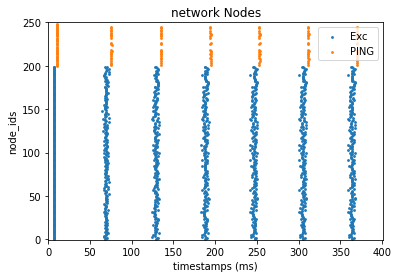

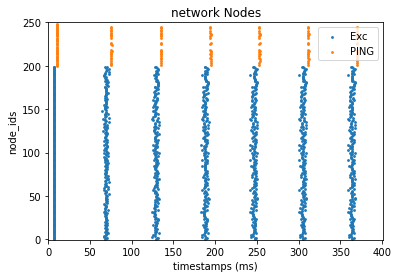

In [8]:
from bmtk.analyzer.spike_trains import plot_raster,plot_rates_boxplot

plot_raster(config_file='simulation_config.json', with_histogram=False, population='network', group_by='pop_name')

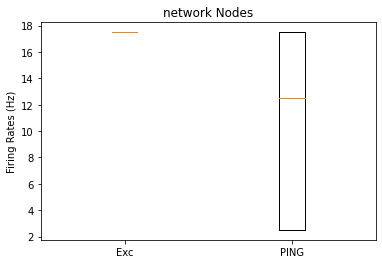

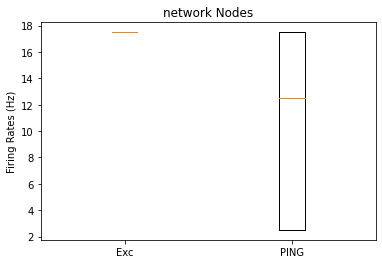

In [9]:
plot_rates_boxplot(config_file='simulation_config.json', group_by='pop_name')

The PING network successfully entrained the E-cells (Exc) at ~20 Hz which is in Beta wave range